In [1]:
import keras
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.model_selection as skmodselect
from keras.src.callbacks import EarlyStopping

In [2]:
#This dataset is taken from the Kaggle Histopathologic Cancer Detection Competition found https://www.kaggle.com/c/histopathologic-cancer-detection/data
# The problem at the heart of this competition is to create a model that is able to label cell images as cancerous or non-cancerous

#The first step is to load the training labels as a pandas dataframe
train_df = pd.read_csv("data/train_labels.csv")

In [3]:
#From the first five rows, it is clear that there is one features for this dataset. The one feature is the id for the image that the label is associated with. However, the training images are in the train directory and so have to be loaded.
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
#The next step is to create a dictionary mapping the image_id with the actual images of the training set. At the same time a list keeps track of any images that don't load or don't exist. Because the training set has 220k records I decided to take a subset to reduce memory costs
image_map = {}
training_images = []
null_images = []
for image_id in train_df["id"][:20000]:
    image = np.array(keras.utils.img_to_array(keras.utils.load_img(f"data/train/{image_id}.tif")))
    training_images.append(image.tolist())
    if image.ndim != 3:
        null_images.append(image_id)
image_map["id"] = train_df["id"][:20000]
image_map["image"] = training_images

In [5]:
#First it is confirmed that all the images were loaded successfully. The dict is converted to a pandas dataframe and joined with the training label dataframe
print(len(null_images))
train_images_df = pd.DataFrame.from_dict(image_map)
train_df2 = train_df[:50000]
full_training_df = train_df2.merge(train_images_df, how="inner", on='id')
full_training_df.head()

0


,id,label,image
0,f38a6374c348f90b587e046aac6079959adf3835,0,"[[[246.0, 246.0, 244.0], [247.0, 247.0, 245.0]..."
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,"[[[251.0, 247.0, 246.0], [253.0, 248.0, 245.0]..."
2,755db6279dae599ebb4d39a9123cce439965282d,0,"[[[255.0, 236.0, 255.0], [126.0, 88.0, 129.0],..."
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,"[[[134.0, 75.0, 169.0], [164.0, 102.0, 188.0],..."
4,068aba587a4950175d04c680d38943fd488d6a9d,0,"[[[93.0, 23.0, 47.0], [147.0, 88.0, 120.0], [6..."


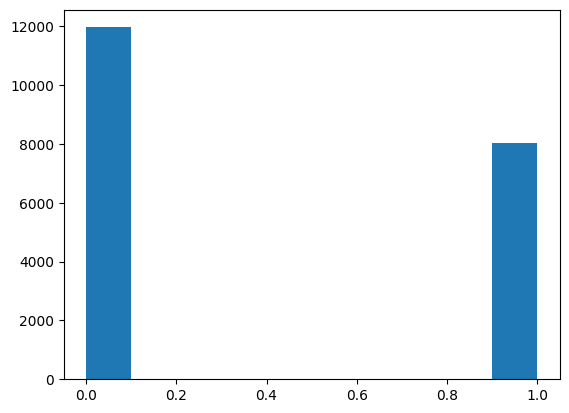

In [6]:
#I then plot the distribution of the labels and then split the data into training and validation sets inorder to compare performance on different models
#plt.hist(train_df.label)
plt.hist(full_training_df.label)
y = full_training_df.label
X = full_training_df.drop("label", axis=1)
X_train,X_val,y_train,y_val = skmodselect.train_test_split(X,y, test_size=0.2, random_state=55)

(array([2438.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1562.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

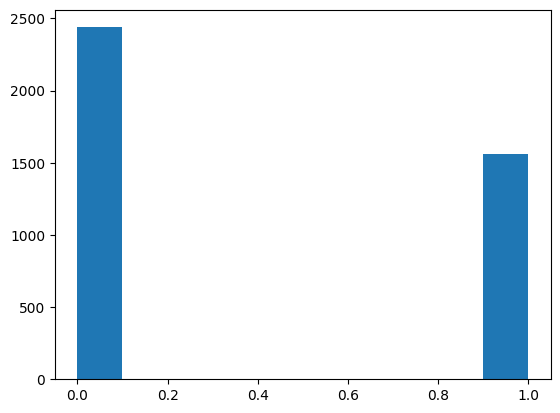

In [7]:
#A quick check to see if validation label distribution matches full training set distribution
plt.hist(y_val)

In [8]:
#I will try to use VGG-11 and VGG-13 for the model architecture. VGG is a good model for image classification and I chose VGG-11/VGG-13 because I wanted to balance performance and accuracy.

#For both VGG models I decided to use 32 filters to start instead of 64 to improve performance and the images are 96x96 instead of the standard 224x224 images
VGG_11_model = keras.models.Sequential()
VGG_11_model.add(keras.layers.Conv2D(input_shape=(96,96,3),filters=32,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_11_model.add(keras.layers.Conv2D(filters=64,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_11_model.add(keras.layers.Conv2D(filters=128,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.Conv2D(filters=128,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_11_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_11_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_11_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_11_model.add(keras.layers.Flatten())
VGG_11_model.add(keras.layers.Dense(units=2304,activation="relu"))
VGG_11_model.add(keras.layers.Dense(units=64,activation="relu"))
VGG_11_model.add(keras.layers.Dense(units=1,activation="sigmoid"))
VGG_11_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])

C:\Users\rrr35\PycharmProjects\kaggle-submissions\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
VGG_13_model = keras.models.Sequential()
VGG_13_model.add(keras.layers.Conv2D(input_shape=(96,96,3),filters=32,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.Conv2D(filters=32,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_13_model.add(keras.layers.Conv2D(filters=64,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.Conv2D(filters=64,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_13_model.add(keras.layers.Conv2D(filters=128,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.Conv2D(filters=128,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_13_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_13_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.Conv2D(filters=256,padding="same",activation="relu",kernel_size=(3,3)))
VGG_13_model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
VGG_13_model.add(keras.layers.Flatten())
VGG_13_model.add(keras.layers.Dense(units=2304,activation="relu"))
VGG_13_model.add(keras.layers.Dense(units=64,activation="relu"))
VGG_13_model.add(keras.layers.Dense(units=1,activation="sigmoid"))
VGG_13_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])

In [10]:
#Get the summary for the VGG 11 model
VGG_11_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2304)           │     5,310,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,764,545 (29.62 MB)

 Trainable params: 7,764,545 (29.62 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Get the summary for the VGG 13 model
VGG_13_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2304)           │     5,310,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,810,721 (29.80 MB)

 Trainable params: 7,810,721 (29.80 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Fit the training data on the VGG 11 model
X_train2 = np.array([np.array(val) for val in X_train.image])
X_val2 = np.array([np.array(val) for val in X_val.image])
VGG_11_model.fit(tf.cast(X_train2, dtype=tf.float32),y_train,validation_split=0.2,batch_size=32,epochs=150,verbose=1,callbacks=[EarlyStopping(monitor='val_loss')])

Epoch 1/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - AUC: 0.6201 - loss: 3.5183 - val_AUC: 0.8503 - val_loss: 0.5487
Epoch 2/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 59s 148ms/step - AUC: 0.8183 - loss: 0.5189 - val_AUC: 0.8649 - val_loss: 0.4644
Epoch 3/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - AUC: 0.8484 - loss: 0.4732 - val_AUC: 0.8642 - val_loss: 0.5207


In [13]:
#Fit the training data on the VGG 13 model
VGG_13_model.fit(tf.cast(X_train2, dtype=tf.float32),y_train,validation_split=0.2,batch_size=32,epochs=150,verbose=1,callbacks=[EarlyStopping(monitor='val_loss')])

Epoch 1/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 61s 149ms/step - AUC: 0.6498 - loss: 1.2791 - val_AUC: 0.6729 - val_loss: 0.6453
Epoch 2/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 97s 243ms/step - AUC: 0.6727 - loss: 0.6253 - val_AUC: 0.8570 - val_loss: 0.4674
Epoch 3/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 94s 236ms/step - AUC: 0.8293 - loss: 0.4993 - val_AUC: 0.8628 - val_loss: 0.4576
Epoch 4/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 95s 238ms/step - AUC: 0.8407 - loss: 0.4868 - val_AUC: 0.8615 - val_loss: 0.4555
Epoch 5/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 107s 268ms/step - AUC: 0.8640 - loss: 0.4530 - val_AUC: 0.8885 - val_loss: 0.4208
Epoch 6/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 93s 231ms/step - AUC: 0.8728 - loss: 0.4408 - val_AUC: 0.8858 - val_loss: 0.4258


In [16]:
#evaluate the two models on the validation set to determine whic model to use
print(VGG_11_model.evaluate(X_val2,y_val))
VGG_13_model.evaluate(X_val2,y_val)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.8642 - loss: 0.5197
[0.5289552211761475, 0.8585546016693115]
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 0.8876 - loss: 0.4189


[0.4307897686958313, 0.8804616332054138]

In [50]:
#From the evaluation step the VGG-13 model appears to be the better option and so we use the testing data to predict
#Prepare the test data
test_files = os.listdir("data/test")
test_image_id = []
test_images = []
for file in test_files:
    test_image_id.append(file.split(".")[0])
    image = keras.utils.img_to_array(keras.utils.load_img('data/test/'+file))
    image = np.reshape(image, (1,image.shape[0], image.shape[1], image.shape[2]))
    test_images.append(np.argmax(VGG_13_model.predict(tf.cast(image, dtype=tf.float32),verbose=0)))
prediction_map = {"id": test_image_id, "label": test_images}
predict_df = pd.DataFrame.from_dict(prediction_map)
predict_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


(array([    0.,     0.,     0.,     0.,     0., 57458.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

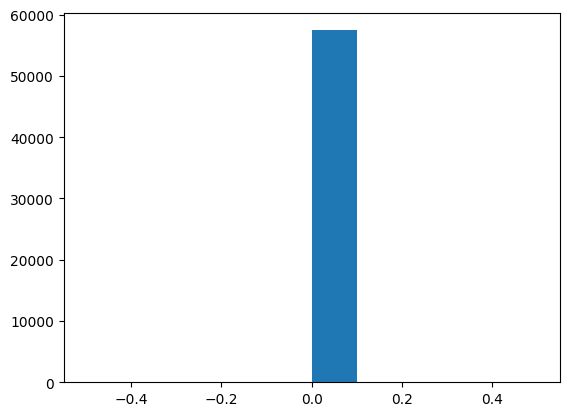

In [51]:
plt.hist(predict_df.label)

In [53]:
predict_df.to_csv("data/submission.csv",index=False)

In [42]:
#Citation: Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection